## Style Transfer
___
#### Description:

Style transfer is the task of taking a content image and a style image and combining them to create a new image with the content of the content image and style of the style image. Style transfer works by optimizing a cost function. This cost function includes a style cost and a content cost. The style cost relates to how similar the style of the generated image is to the style image, and the content cost relates to how similar the content of the generated image is to the content image. The lower the content cost, the more similar the generated image will look like the content image, and the lower the style cost, the more style of the style image the generated image will have. By minimizing this cost and choosing good hyperparameters we are able to generate pretty cool images. Note that instead of optimizing weights as we do for standard neural networks, we optimize the pixel values of the generated image.
___

#### Reference:

This code is based heavily on the Andrew Ng Deep Learning Coursera coding assignment on Style Transfer. A fair amount of modifications have been applied and some things have been added but the hyperparameters remain the same. 

The paper on Style Transfer can be found here: https://arxiv.org/abs/1508.06576

The .mat file containing the VGG19 model can be downloaded from here:
http://www.vlfeat.org/matconvnet/pretrained/#imagenet-ilsvrc-classification 

## Import dependencies
___

In [2]:
import numpy as np
import tensorflow as tf
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

## Set default arguments
___

In [3]:
OUTPUT_DIR = 'Outputs/'

IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512
NUM_CHANNELS = 3

MEANS = np.array([123.68, 116.779, 103.939]) #VGG mean
NOISE_RATIO = 0.6

CONTENT_LAYER = 'conv4_2'

STYLE_LAYERS = [('conv1_1', 0.2),
                ('conv2_1', 0.2),
                ('conv3_1', 0.2),
                ('conv4_1', 0.2),
                ('conv5_1', 0.2)]

ALPHA = 10
BETA = 40

## Helper functions for constructing graph
___

In [4]:
# Gets parameters from a layer
def get_params(layer):
    global layers
    params = layers[0][layer][0][0][2][0]
    W = params[0]
    b = params[1]
    return W, b

# Gets the name of a layer
def get_name(layer):
    global layers
    name = layers[0][layer][0][0][0][0]
    return name

# Performs convolution and applies a relu activation
def conv2d_relu(prev_layer, layer):
    W, b = get_params(layer)
    W = tf.constant(W)
    b = tf.constant(b.ravel())
    return tf.nn.relu(tf.nn.conv2d(prev_layer, W, strides=[1, 1, 1, 1], padding='SAME') + b)

# Performs average pooling
def avg_pool(prev_layer):
    return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')    


## Function that  constructs the graph
___

In [5]:
def construct_graph(layers):

    # Make a list containing all layers (including intermediate layers)
    num_layers = len(layers[0]) 
    layer_names = []
    for layer in range(num_layers):
        name = get_name(layer)    
        layer_names.append(name)
    
    # Construct graph excluding fully-connected layers
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, 512, 512, 3)), dtype = 'float32')
    prev_name = 'input'

    for layer, name in enumerate(layer_names):    
        if 'conv' in name:
            graph[name] = conv2d_relu(graph[prev_name], layer)
            prev_name = name
        if 'pool' in name:
            graph[name] = avg_pool(graph[prev_name])
            prev_name = name        
    return graph

## Functions for preprocessing images
___

In [6]:
# Standardizes the image and expands the dimensions
def preprocess_image(image):
    image = image - MEANS
    image = np.expand_dims(image, axis=0)
    return image

In [7]:
# Generates a noisy image which will be used as the initial generated image
def generate_noise_image(content_image, noise_ratio = NOISE_RATIO):
    noise = np.random.uniform(-20, 20, (content_image.shape))
    noise_image = noise * noise_ratio + content_image * (1 - noise_ratio)
    return noise_image

In [8]:
# Define a function that saves an image
def save_image(image, name):
    image = image + MEANS
    image = np.clip(image[0], 0, 255).astype('uint8')
    path = OUTPUT_DIR + name + '.jpg'
    scipy.misc.imsave(path, image)

## Helper function that computes the Gram matrix
___

In [9]:
# Computes the gram matrix for a 2D array
def gram_matrix(A):
    return tf.matmul(A, tf.transpose(A))

## Functions to compute content cost & style cost
___

In [10]:
# Computes the content cost
def compute_content_cost(A_content_in, A_generated_in):
    return 0.5 * tf.reduce_mean(tf.square(A_content_in - A_generated_in)) 

In [11]:
# Computes the style cost for a single style layer
def compute_style_cost(A_style_in, A_generated_in):

    # Reshape tensors to the appropriate shape and orientation
    _, height, width, channels = A_generated_in.get_shape().as_list()
    A_style_in = tf.transpose(tf.reshape(A_style_in, [height*width, channels]))
    A_generated_in = tf.transpose(tf.reshape(A_generated_in, [height*width, channels]))

    # Compute Gram matrices
    style_gram = gram_matrix(A_style_in)
    generated_gram = gram_matrix(A_generated_in)

    # Compute style cost
    style_cost = 1/(4*channels**2*(height*width)**2) * tf.reduce_sum(tf.square(style_gram - generated_gram))
    
    return style_cost

## Read in content & style images and prepare them
___
Make sure image shape is consistent with *IMAGE_HEIGHT*, *IMAGE_WIDTH* and *NUM_CHANNELS*.

Image shape: (1, 512, 512, 3)


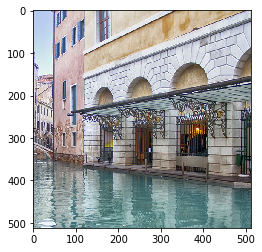

In [12]:
# Read and prepare content image
content_image = scipy.misc.imread('Images/venice.jpg')[:512,400:912,:]
plt.imshow(content_image)

content_image = preprocess_image(content_image)
print('Image shape:', content_image.shape)

Image shape: (1, 512, 512, 3)


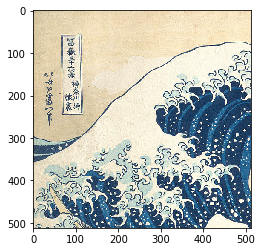

In [13]:
# Read and prepare style image
style_image = scipy.misc.imread('Images/great_wave_of_kanegawa.jpg')[:512,:512,:]
plt.imshow(style_image)

style_image = preprocess_image(style_image)
print('Image shape:', style_image.shape)

## Initialize the generated image
___

Image shape: (1, 512, 512, 3)


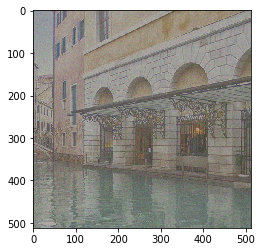

In [14]:
generated_image = generate_noise_image(content_image)
plt.imshow((generated_image[0] + MEANS).astype('uint8'))
print('Image shape:', generated_image.shape)

## Load the model
___

In [15]:
vgg = scipy.io.loadmat('imagenet-vgg-verydeep-19')
layers = vgg['layers']

## Create a session and construct the graph
___

In [16]:
# Reset the graph
tf.reset_default_graph()

# Create a session
sess = tf.InteractiveSession()

# Construct graph
graph = construct_graph(layers)

In [17]:
# Information on the graph
graph

{'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 512, 512, 64) dtype=float32>,
 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 512, 512, 64) dtype=float32>,
 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 256, 256, 128) dtype=float32>,
 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 256, 256, 128) dtype=float32>,
 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 128, 128, 256) dtype=float32>,
 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 128, 128, 256) dtype=float32>,
 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 128, 128, 256) dtype=float32>,
 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 128, 128, 256) dtype=float32>,
 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 64, 64, 512) dtype=float32>,
 'conv4_2': <tf.Tensor 'Relu_9:0' shape=(1, 64, 64, 512) dtype=float32>,
 'conv4_3': <tf.Tensor 'Relu_10:0' shape=(1, 64, 64, 512) dtype=float32>,
 'conv4_4': <tf.Tensor 'Relu_11:0' shape=(1, 64, 64, 512) dtype=float32>,
 'conv5_1': <tf.Tensor 'Relu_12:0' shape=(1, 32, 32, 512) dtype=float32>,
 'conv5_2': <tf.Tensor 'Relu_13:0' s

* Run the content and style image through the graph to obtain their respective layer activations.
* Set up operations to compute costs.
* Set up the optimizer.


In [18]:
# Run the content image through the graph
sess.run(graph['input'].assign(content_image))

# Select content layer
content_layer = graph[CONTENT_LAYER] # Tensor

# Obtain content layer activation with content image input
A_content_in = sess.run(content_layer) # Array

# Content cost
content_cost = compute_content_cost(A_content_in, content_layer)

In [19]:
# Run the style image through the graph
sess.run(graph['input'].assign(style_image))

style_cost = 0

# Iterate through the style layers
for layer, coef in STYLE_LAYERS:    
    style_layer = graph[layer] # Tensor
    A_style_in = sess.run(style_layer) # Array
    # Style cost for layer
    style_cost_single = compute_style_cost(A_style_in, style_layer)
    # Style cost for all style layers
    style_cost += coef * style_cost_single
    

# sess.run(graph['input'].assign(style_image))

# # Iterate through the style layers
# style_layers_list = []
# for layer, coef in STYLE_LAYERS:    
#     style_layer = graph[layer] # Tensor
#     A_style_in = sess.run(style_layer) # Array
#     style_layers_list.append(A_style_in)

# i = 0
# style_cost = 0
# for layer, coef in STYLE_LAYERS:  
#     style_layer = graph[layer] # Tensor
#     # Style cost for layer
#     style_cost_single = compute_style_cost(style_layers_list[i], style_layer)
#     # Style cost for all style layers
#     style_cost += coef * style_cost_single
#     count += 1

In [20]:
# Total cost
total_cost = ALPHA * content_cost + BETA * style_cost

In [21]:
# Training step
train_step = tf.train.AdamOptimizer(2.0).minimize(total_cost)

## Define a model to perform training
___

In [22]:
def model(sess, generated_image, num_iterations = 200):
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    # Run the initial generated image through the graph
    sess.run(graph['input'].assign(generated_image))
    
    # Training
    for i in range(num_iterations):
        
        # One training step
        sess.run(train_step)
        
        # Update the generated image
        generated_image = sess.run(graph['input'])

        # Print cost every 20 iterations
        if i%20 == 0:
            total_c, content_c, style_c = sess.run([total_cost, content_cost, style_cost])
            print('Iteration ' + str(i) + ':')
            print('total cost =\t' + str(total_c))
            print('content cost =\t' + str(content_c))
            print('style cost =\t' + str(style_c))
            
            # Save the generated image every 20 iterations
            save_image(generated_image, '_iteration_' + str(i))
    
    # Save final generated image
    save_image(generated_image, 'generated_image')
    
    return generated_image

In [23]:
# Run the model
final_image = model(sess, generated_image)

Iteration 0:
total cost =	8219974000.0
content cost =	13634.079
style cost =	205495950.0
Iteration 20:
total cost =	2286228500.0
content cost =	29586.031
style cost =	57148310.0
Iteration 40:
total cost =	1068268160.0
content cost =	34564.242
style cost =	26698062.0
Iteration 60:
total cost =	623132000.0
content cost =	36711.855
style cost =	15569123.0
Iteration 80:
total cost =	438047400.0
content cost =	38243.3
style cost =	10941624.0
Iteration 100:
total cost =	343718300.0
content cost =	39300.875
style cost =	8583132.0
Iteration 120:
total cost =	285842660.0
content cost =	40130.246
style cost =	7136034.0
Iteration 140:
total cost =	245481860.0
content cost =	40800.27
style cost =	6126846.5
Iteration 160:
total cost =	214995490.0
content cost =	41360.06
style cost =	5364547.0
Iteration 180:
total cost =	190734020.0
content cost =	41848.105
style cost =	4757888.5


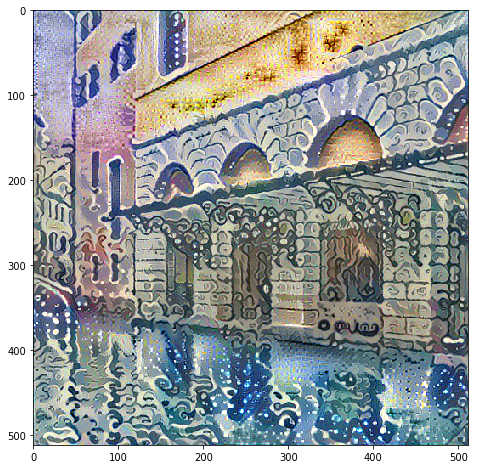

In [24]:
# Display final image
image = np.clip(final_image[0] + MEANS, 0, 255).astype('uint8')
plt.figure(figsize=(8,8))
plt.imshow(image)